# Detection and Classification of Ultrasonic Vocalizations (USVs) in Rodent Audio Data

In this notebook, we will demonstrate how to **detect** and **classify** ultrasonic vocalizations (USVs) in rodent audio recordings using spectrogram analysis, Geodesic Active Contours (GAC) for segmentation, and a Convolutional Neural Network (CNN) for classification.

## Overview

- **Load Audio Data**: Start by loading an audio file containing rodent vocalizations.
- **Generate Spectrogram**: Create a spectrogram of a selected segment of the audio data to visualize the frequency content over time.
- **Detect USVs**: Use Geodesic Active Contours (GAC) to detect potential USVs in the spectrogram.
- **Classify USVs**: Classify the detected USVs using a pre-trained CNN model to distinguish between different types of vocalizations.

## Importing Libraries

We begin by importing the necessary libraries:

- **torchaudio**: For loading and processing audio data.
- **matplotlib.pyplot**: For plotting and visualizing data.
- **mouse.utils**, **mouse.segmentation**, **mouse.classifier**: Custom modules for sound utilities, segmentation, and classification specific to mouse USVs.
- **pathlib**, **os**: For handling file paths and operating system interactions.
- **typing**, **functools**, **copy**, **tqdm**: For type annotations, function tools, copying objects, and progress bars.


In [21]:
import torchaudio
import matplotlib.pyplot as plt
from mouse.utils import sound_util, visualization, data_util
from mouse.segmentation import segmentation, GAC
import pathlib
from typing import List, Dict, Optional, Callable, Union
from functools import partial
import copy
from tqdm import tqdm

## Loading the Audio File
We will load the audio file containing the rodent vocalizations.

### Note
Please ensure that the audio file `long-example-rodent.wav` or `short-example-rodent.wav` is present in your working directory.

In [22]:
file_path = "long-example-rodent.wav"
waveform, sample_rate = torchaudio.load(file_path)

## Generating the Spectrogram

Next, we will generate a spectrogram of the audio data to visualize its frequency content over time.

### Function Parameters

The `generate_spectrogram` function generates and plots a spectrogram for the given signal data.

**Parameters:**

- `signal_data` (*sound_util.SignalData*): The signal data containing the waveform and sample rate.
- `n_fft` (*int*, optional): The size of FFT, creates `n_fft // 2 + 1` bins. Default is `400`.
- `win_length` (*int*, optional): Window size. Default is `n_fft`.
- `hop_length` (*int*, optional): Length of hop between STFT windows. Default is `win_length // 2`.
- `power` (*float*, optional): Exponent for the magnitude spectrogram. Default is `2.0`.
- `center` (*bool*, optional): Whether to pad the input on both sides so that the `t`-th frame is centered at time `t * hop_length`. Default is `True`.
- `pad_mode` (*str*, optional): Controls the padding method used when `center` is `True`. Default is `'reflect'`.
- `vmax` (*float*, optional): The maximum value for the color scale in the spectrogram plot. Default is `5`.
- `t_start` (*float*, optional): The start time (in seconds) for the spectrogram. Default is `None` (start from the beginning).
- `t_end` (*float*, optional): The end time (in seconds) for the spectrogram. Default is `None` (go until the end).

**Returns:**

- `spec_data` (*sound_util.SpectrogramData*): The spectrogram data object containing the spectrogram and related information.

In [23]:
def generate_spectrogram(
    signal_data: sound_util.SignalData,
    n_fft=400,
    win_length=None,
    hop_length=None,
    power=2.0,
    center=True,
    pad_mode='reflect',
    vmax=5,
    t_start: Optional[float] = None,
    t_end: Optional[float] = None
):
    
    # Set default window length and hop length if not provided
    win_length = n_fft if win_length is None else win_length
    hop_length = win_length // 2 if hop_length is None else hop_length

    # Create a spectrogram transform
    spectrogram_transform = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=center,
        pad_mode=pad_mode,
        power=power
    )

    # Compute the spectrogram for the whole signal
    spec_data = sound_util.spectrogram(
        signal_data.signal,
        sample_rate=signal_data.sample_rate,
        spec_calculator=spectrogram_transform,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=power
    )

    # Clip the spectrogram to the selected time window, if specified
    if t_start is not None or t_end is not None:
        spec_data = sound_util.clip_spectrogram(
            spec_data,
            t_start=t_start,
            t_end=t_end
        )

    # Plot the spectrogram
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_facecolor('#2e004f')
    spectrogram_color_mesh = visualization.draw_spectrogram(
        spec_data,
        ax=ax,
        vmax=vmax
    )

    fig.colorbar(spectrogram_color_mesh, ax=ax, format='%+2.0f dB')
    ax.set_title('Spectrogram', color='white')
    ax.set_xlabel('Time [s]', color='white')
    ax.set_ylabel('Frequency [kHz]', color='white')
    ax.tick_params(colors='white')

    fig.patch.set_facecolor('black')
    fig.show()
    
    return spec_data


### Loading the Signal Data and Generating the Spectrogram

We will create a `SignalData` object from the audio file and generate the spectrogram for a specific time window.


name: long-example-rodent.wav, length: 9.8863 [s]


/var/folders/l6/wgftfmzx72z5zmyqxrjk74wh0000gn/T/ipykernel_49652/1851535485.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


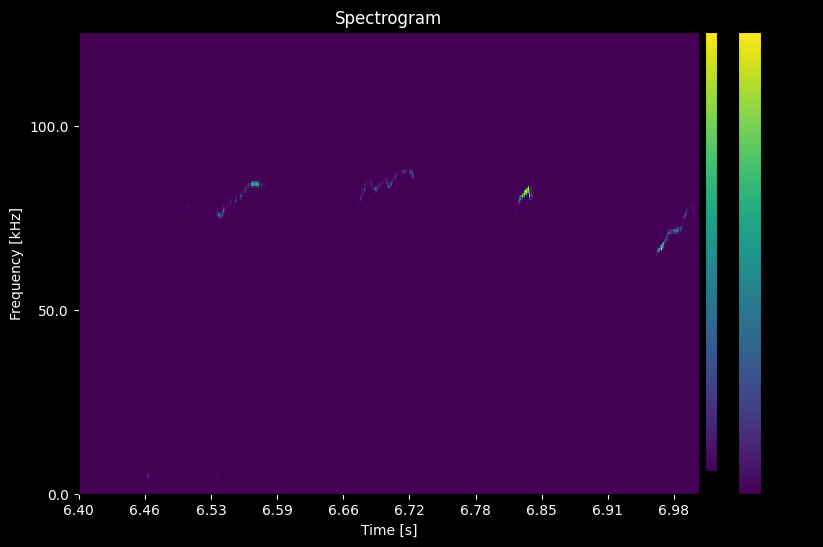

In [24]:
# Create a SignalData object from the audio file
signal_data = sound_util.SignalData(pathlib.Path(file_path))
print(signal_data)

# Generate the spectrogram for a specific time window
spec_data = generate_spectrogram(
    signal_data,
    t_start=6.4,  # Start time in seconds
    t_end=7    # End time in seconds
)

## Detecting USVs Using Geodesic Active Contours (GAC)

We will use the Geodesic Active Contour (GAC) method to detect USVs in the spectrogram. This method allows us to segment the spectrogram and find regions that correspond to USVs.

### Function Parameters

The `find_USVs_GAC` function finds USVs on a spectrogram using GAC.

**Parameters:**

- `spec` (*sound_util.SpectrogramData*): The spectrogram data to search for USVs.
- `min_side_length` (*int*): Minimum side length for bounding boxes. Default is `1`.
- `filter` (*bool*): Whether to filter USVs' bounding boxes. Default is `True`.
- `preprocessing_fn` (*Callable*, optional): Function for preprocessing the spectrogram `spec`. Default is `None`.
- `level_set` (*Callable*, optional): Function for generating the initial level set based on preprocessed `spec`. Default is `None`.
- `tqdm_kwargs` (*dict*, optional): Keyword arguments for the `tqdm` progress bar. Default is `None`.
- `**kwargs`: Additional arguments passed to `morphological_geodesic_active_contour` from `skimage.segmentation`.

**Returns:**

- `List[data_util.SqueakBox]`: List of detected USVs' bounding boxes.



In [25]:
def find_USVs_GAC(spec: sound_util.SpectrogramData,
                  min_side_length=1,
                  filter=True,
                  preprocessing_fn: Optional[Callable] = None,
                  level_set: Callable = None,
                  tqdm_kwargs: Optional[Dict] = None,
                  **kwargs) -> List[data_util.SqueakBox]:

    _kwargs = copy.deepcopy(kwargs)

    # Set default preprocessing function if not provided
    if preprocessing_fn is None:
        preprocessing_fn = partial(segmentation.inverse_gaussian_gradient,
                                   sigma=5,
                                   alpha=100)
    # Set default parameters for GAC if not provided
    for arg, val in [
        ("num_iter", 230),
        ("smoothing", 0),
        ("threshold", 0.9),
        ("balloon", -1),
    ]:
        if arg not in _kwargs:
            _kwargs[arg] = val

     # Preprocess the spectrogram
    _spec = preprocessing_fn(spec.spec.numpy())

    # Set default level set function if not provided
    if level_set is None:
        level_set = GAC.ones_level_set

    level_set_init = level_set(_spec)

    tqdm_kwargs = tqdm_kwargs if tqdm_kwargs else {}
    with tqdm(total=_kwargs["num_iter"], **tqdm_kwargs) as pbar:
        if 'iter_callback' in _kwargs:
            callback = _kwargs['iter_callback']

            def _iter_callback(level_set):
                callback(level_set)
                pbar.update(1)

            _kwargs['iter_callback'] = _iter_callback

        # Ensure no 'iterations' keyword is passed
        if 'iterations' in _kwargs:
            del _kwargs['iterations']

        # Run the GAC algorithm
        level_set_result = segmentation.morphological_geodesic_active_contour(
            _spec, init_level_set=level_set_init, **_kwargs)

    # Find bounding boxes for the detected regions
    boxes = data_util.find_bounding_boxes(level_set_result,
                                          min_side_length=min_side_length)

    # Filter the bounding boxes if required
    if filter:
        return data_util.filter_boxes(spec, boxes)
    else:
        return boxes

### Detecting USVs in the Spectrogram

We will apply the `find_USVs_GAC` function to detect USVs in the spectrogram.

In [26]:
# Detect USVs using GAC
detected_squeaks = find_USVs_GAC(
    spec=spec_data,
    min_side_length=1,
    tqdm_kwargs={"desc": "Detecting USVs with GAC"}
)

Detecting USVs with GAC:   0%|          | 0/230 [00:00<?, ?it/s]


### Visualizing the Detected USVs

We will now visualize the detected USVs by plotting bounding boxes over the spectrogram.

/var/folders/l6/wgftfmzx72z5zmyqxrjk74wh0000gn/T/ipykernel_49652/1104501486.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


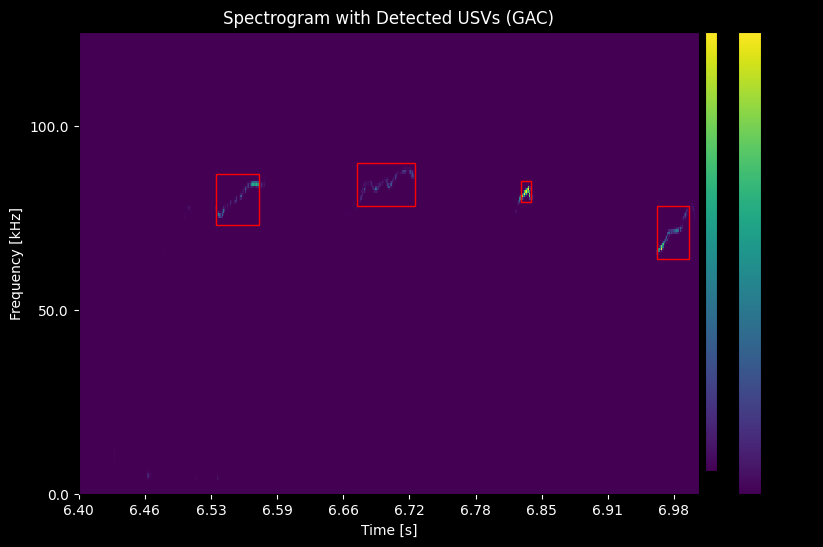

In [27]:
# Plotting the detected USVs on the spectrogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#2e004f')  # Set axes background color (dark purple)

spectrogram_color_mesh = visualization.draw_spectrogram(
    spec_data,
    ax=ax,
    vmax=5
)

# Draw bounding boxes around detected USVs
for squeak_box in detected_squeaks:
    rect = plt.Rectangle(
        (squeak_box.t_start, squeak_box.freq_start),
        squeak_box.t_end - squeak_box.t_start,
        squeak_box.freq_end - squeak_box.freq_start,
        linewidth=1,
        edgecolor='r',  # Red color for bounding boxes
        facecolor='none'
    )
    ax.add_patch(rect)

fig.colorbar(spectrogram_color_mesh, ax=ax, format='%+2.0f dB')
ax.set_title('Spectrogram with Detected USVs (GAC)', color='white')
ax.set_xlabel('Time [s]', color='white')
ax.set_ylabel('Frequency [kHz]', color='white')
ax.tick_params(colors='white')

fig.patch.set_facecolor('black')  # Set the figure background color to black

fig.show()

## Classifying Detected USVs Using Simple Thresholding

After detecting the USVs, we will classify them using a simple frequency-based thresholding method to determine whether they are high-frequency or low-frequency vocalizations.

### Function Parameters

The `classify_USVs` function classifies USVs based on a frequency threshold.

**Parameters:**

- `spec` (*sound_util.SpectrogramData*): A spectrogram from which `squeak_boxes` come from.
- `squeak_boxes` (*List[SqueakBox]*): List of `SqueakBox` objects representing detected USVs.
- `threshold` (*Union[int, float]*): Frequency threshold (in kHz) that divides USVs into high and low frequency.
- `low_label` (*str*): Label to assign to low-frequency USVs. Default is `'low freq'`.
- `high_label` (*str*): Label to assign to high-frequency USVs. Default is `'high freq'`.
- `callback` (*Optional[Callable]*): Function called after each `SqueakBox` is processed. Default is `None`.

**Returns:**

- `List[data_util.SqueakBox]`: List of annotated USVs with labels based on frequency classification.

In [28]:
def classify_USVs(
    spec: sound_util.SpectrogramData,
    squeak_boxes: List[data_util.SqueakBox],
    threshold: Union[int, float],
    low_label: str = "low freq",
    high_label: str = "high freq",
    callback: Optional[Callable] = None,
):
    # Convert the frequency threshold to pixel units if it's in Hz
    if isinstance(threshold, float):
        threshold = spec.freq_to_pixels(threshold)
    for squeak_box in squeak_boxes:
        mean_freq = (squeak_box.freq_end + squeak_box.freq_start) / 2
        if mean_freq > threshold:
            squeak_box.label = high_label
        else:
            squeak_box.label = low_label
        if callback is not None:
            callback()

    return squeak_boxes

### Classifying the Detected USVs

We will now classify the detected USVs using the simple thresholding method. We'll set a frequency threshold (e.g., 50 kHz) to distinguish between high-frequency and low-frequency vocalizations.

In [29]:
# Set the frequency threshold in kHz
threshold_frequency = 50.0  # Threshold at 50 kHz

# Classify the detected USVs
classified_squeaks = classify_USVs(
    spec=spec_data,
    squeak_boxes=detected_squeaks,
    threshold=threshold_frequency,
    low_label='low freq',
    high_label='high freq'
)

### Visualizing the Classified USVs

We will visualize the classified USVs by plotting bounding boxes with different colors based on their classification.

/var/folders/l6/wgftfmzx72z5zmyqxrjk74wh0000gn/T/ipykernel_49652/4102808610.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


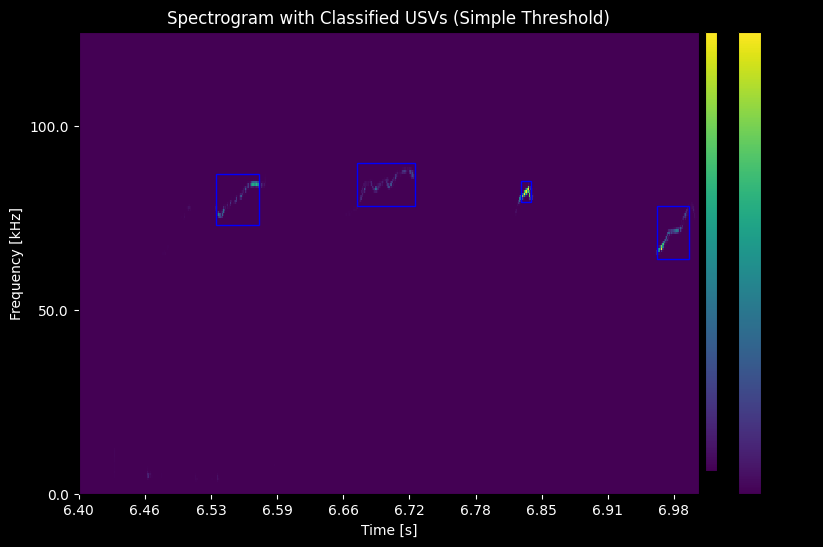

In [30]:
# Plotting the classified USVs on the spectrogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#2e004f')  # Set axes background color (dark purple)

spectrogram_color_mesh = visualization.draw_spectrogram(
    spec_data,
    ax=ax,
    vmax=5
)

# Draw bounding boxes around classified USVs with different colors
for squeak_box in classified_squeaks:
    color = 'b' if squeak_box.label == "high freq" else 'g'  # Blue for 'high freq', green otherwise
    rect = plt.Rectangle(
        (squeak_box.t_start, squeak_box.freq_start),
        squeak_box.t_end - squeak_box.t_start,
        squeak_box.freq_end - squeak_box.freq_start,
        linewidth=1,
        edgecolor=color,
        facecolor='none'
    )
    ax.add_patch(rect)

fig.colorbar(spectrogram_color_mesh, ax=ax, format='%+2.0f dB')
ax.set_title('Spectrogram with Classified USVs (Simple Threshold)', color='white')
ax.set_xlabel('Time [s]', color='white')
ax.set_ylabel('Frequency [kHz]', color='white')
ax.tick_params(colors='white')

fig.patch.set_facecolor('black')  # Set the figure background color to black

fig.show()

## Conclusion

In this notebook, we demonstrated how to detect and classify ultrasonic vocalizations (USVs) in rodent audio recordings using a simple frequency-based thresholding method. We:

- Loaded and visualized the audio data using spectrograms.
- Detected USVs using Geodesic Active Contours (GAC).
- Classified the detected USVs based on a frequency threshold.
- Visualized the results by plotting bounding boxes over the spectrogram.

This approach provides a straightforward method for analyzing rodent vocalizations and can be useful in research settings where quick classification is needed.